# FOOD ANALYSIS
In this kernel I'll provide an overview on FAO dataset. In particular, after a cleaning of the dataset, I'll show the most productive countries and items providing an overview and description of the dataset. I'll also apply clustering algorithms on a subset of the full dataset in order to find if something interesting comes out.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py 
import plotly.graph_objs as go
import scipy.cluster.hierarchy as shc
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.preprocessing import StandardScaler
import os

df = pd.read_csv("../input/world-foodfeed-production/FAO.csv",  encoding = "ISO-8859-1")
df.head()

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,AFG,2,Afghanistan,2511,Wheat and products,5142,Food,1000 tonnes,33.94,67.71,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,33.94,67.71,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley and products,5521,Feed,1000 tonnes,33.94,67.71,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley and products,5142,Food,1000 tonnes,33.94,67.71,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize and products,5521,Feed,1000 tonnes,33.94,67.71,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


# DATA DESCRIPTION

Each row of this dataset contains the amount (values represent 1000 tonnes) of Feed/Food produced by each country ( 'Area' ) from 1961 to 2013 for a particular Item. 

More metadata are included such as Area Abbreviation, Area/Item/Element Code, latitude, longitude, not used in this analysis. 

The dataset is reduced containg only columns: Area, Item, Element, Y1961-Y2013

In [2]:
df.dtypes[:20]

Area Abbreviation     object
Area Code              int64
Area                  object
Item Code              int64
Item                  object
Element Code           int64
Element               object
Unit                  object
latitude             float64
longitude            float64
Y1961                float64
Y1962                float64
Y1963                float64
Y1964                float64
Y1965                float64
Y1966                float64
Y1967                float64
Y1968                float64
Y1969                float64
Y1970                float64
dtype: object

### ADDITION OF POPULATION AND SURFACE DIMENSIONS

In order to make analysis richer I've decided to add to this dataset information about the population and the surface area of each country. 

Data is taken again from FAO stats website, considering the year of 2013.  

Population data is specify as Million of people.
Surface area instead as 1000 acres.

Datasets are merged with existing dataset considering 'Area' as key.


In [3]:
#In order to not have problems of consistency:
df['Area'].replace(['Swaziland'], 'Eswatini', inplace=True)
df['Area'].replace(['The former Yugoslav Republic of Macedonia'], 'North Macedonia', inplace=True)

#GET NEW DATA
df_pop = pd.read_csv("../input/world-population/FAOSTAT_data_6-13-2019.csv")
df_area = pd.read_csv("../input/countries-area-2013/countries_area_2013.csv")
df_pop = pd.DataFrame({'Area': df_pop['Area'] , 'Population': df_pop['Value'] })
df_area = pd.DataFrame({'Area' : df_area['Area'], 'Surface': df_area['Value']})
#add missing line
df_area = df_area.append({'Area' : 'Sudan' , 'Surface' : 1886} , ignore_index=True)

#MERGE OF TABLES
d1 = pd.DataFrame(df.loc[:, ['Area', 'Item', 'Element']])
data = pd.merge(d1, df_pop, on='Area', how='left')
new_data = pd.merge(data, df_area, on='Area', how='left')

d2 = df.loc[:, 'Y1961':'Y2013']
data = new_data.join(d2)
data.head()

,Area,Item,Element,Population,Surface,Y1961,Y1962,Y1963,Y1964,Y1965,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,Afghanistan,Wheat and products,Food,35530.081,65286.0,1928.0,1904.0,1666.0,1950.0,2001.0,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,Afghanistan,Rice (Milled Equivalent),Food,35530.081,65286.0,183.0,183.0,182.0,220.0,220.0,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,Afghanistan,Barley and products,Feed,35530.081,65286.0,76.0,76.0,76.0,76.0,76.0,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,Afghanistan,Barley and products,Food,35530.081,65286.0,237.0,237.0,237.0,238.0,238.0,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,Afghanistan,Maize and products,Feed,35530.081,65286.0,210.0,210.0,214.0,216.0,216.0,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


In [4]:
print('Number of different Countries: ' , df['Area'].unique().size)
print('Number of different Items: ' , df['Item'].unique().size)

Number of different Countries:  174
Number of different Items:  115


# DATA CLEANING

Datasets of this kind mostly of the time contains missing values, represented by NaN. 

Let's see if there are some missing values on this dataset. Each yellow line represent some missing values, is possible to understand that there are a lot of them, the biggest part are before 1991. 
This is because in those period (end of cold war) a lot of new countries were born. 

According to this constraint different ways of proceeding may be taken into consideration, one is to compute analysis only from 1993 where there are a less amount of missing values and computing analisys only for the last 2 decade 1993-2013. 
The other way is to considering all the years removing from analysis the missing rows and so the missing countries.
There is even the possibility to substitute NaN with 0


I decide to substitute missing values with 0 in order to make ranking and then considering only the last 20 years for the clustering analysis, due to a less amount of missing values limiting this constraint.

Let's visualize bettere those missing values.

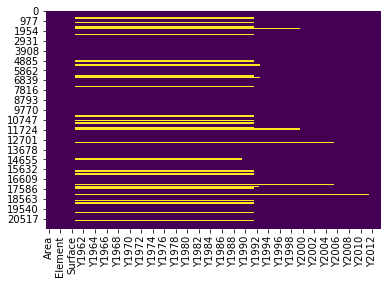

In [5]:
#Graph of missing values
sns.heatmap(data.isnull(),cbar=False,cmap='viridis')   
plt.show()

From this graph is possible to visualize missing values represented by yellow lines, only the last two years doesn't contains missing values.

In [6]:
# Total number of missing values per year
print('YEAR  MISSING VALUES')
print (df.loc[:, 'Y1961':'Y2013'].isnull().sum())

YEAR  MISSING VALUES
Y1961    3539
Y1962    3539
Y1963    3539
Y1964    3539
Y1965    3539
Y1966    3539
Y1967    3539
Y1968    3539
Y1969    3539
Y1970    3539
Y1971    3539
Y1972    3539
Y1973    3539
Y1974    3539
Y1975    3539
Y1976    3539
Y1977    3539
Y1978    3539
Y1979    3539
Y1980    3539
Y1981    3539
Y1982    3539
Y1983    3539
Y1984    3539
Y1985    3539
Y1986    3539
Y1987    3539
Y1988    3539
Y1989    3539
Y1990    3415
Y1991    3415
Y1992     987
Y1993     612
Y1994     612
Y1995     612
Y1996     612
Y1997     612
Y1998     612
Y1999     612
Y2000     349
Y2001     349
Y2002     349
Y2003     349
Y2004     349
Y2005     349
Y2006     104
Y2007     104
Y2008     104
Y2009     104
Y2010     104
Y2011     104
Y2012       0
Y2013       0
dtype: int64


In [7]:
df1 = data[data.isna().any(axis=1)]
df1.head()

,Area,Item,Element,Population,Surface,Y1961,Y1962,Y1963,Y1964,Y1965,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
679,Armenia,Wheat and products,Feed,2930.45,2847.0,NaN,NaN,NaN,NaN,NaN,...,69.0,59.0,46.0,67.0,57.0,56.0,61.0,65.0,92,93
680,Armenia,Wheat and products,Food,2930.45,2847.0,NaN,NaN,NaN,NaN,NaN,...,490.0,433.0,445.0,412.0,428.0,391.0,372.0,386.0,377,389
681,Armenia,Rice (Milled Equivalent),Feed,2930.45,2847.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
682,Armenia,Rice (Milled Equivalent),Food,2930.45,2847.0,NaN,NaN,NaN,NaN,NaN,...,11.0,14.0,17.0,15.0,13.0,13.0,11.0,9.0,9,9
683,Armenia,Barley and products,Feed,2930.45,2847.0,NaN,NaN,NaN,NaN,NaN,...,68.0,57.0,33.0,86.0,76.0,102.0,86.0,124.0,121,137


In [8]:
#Total number of missing values for Area
values_per_area = data.pivot_table(index=['Area'], aggfunc='size')
df1 = data[data.isna().any(axis=1)]
df_missing_area = df1.pivot_table(index=['Area'], aggfunc='size')
df_missing_area

Area
Armenia                   133
Azerbaijan                124
Belarus                   131
Belgium                   136
Bosnia and Herzegovina    124
Croatia                   129
Czechia                   129
Estonia                   135
Ethiopia                  116
Georgia                   133
Kazakhstan                141
Kyrgyzstan                124
Latvia                    136
Lithuania                 140
Luxembourg                127
Montenegro                118
North Macedonia           130
Oman                      124
Republic of Moldova       130
Russian Federation        137
Serbia                    127
Slovakia                  130
Slovenia                  132
Sudan                     104
Tajikistan                102
Turkmenistan               90
Ukraine                   134
Uzbekistan                123
dtype: int64

Countries shown in the list above represent the one for which there are missing values. 

The biggest part are countries born after the dissolve of Jugoslavia and URSS

# RANKING



In [9]:
year_list = list(df.iloc[:,10:].columns)
df_new = df.pivot_table(values=year_list,columns = 'Element', index=['Area'], aggfunc='sum') #for each country sum over years separatly Food&Feed
df_fao = df_new.T
df_fao.head()

Area           Afghanistan  Albania  Algeria  Angola  Antigua and Barbuda  \
      Element                                                               
Y1961 Feed           720.0     94.0     83.0   118.0                  2.0   
      Food          8761.0   1612.0   7405.0  4716.0                 90.0   
Y1962 Feed           720.0    108.0     94.0   118.0                  2.0   
      Food          8694.0   1641.0   7141.0  4657.0                 92.0   
Y1963 Feed           736.0    124.0     63.0   116.0                  2.0   

Area           Argentina  Armenia  Australia  Austria  Azerbaijan  ...  \
      Element                                                      ...   
Y1961 Feed        9552.0      0.0     7813.0   9539.0         0.0  ...   
      Food       33850.0      0.0    17982.0  13003.0         0.0  ...   
Y1962 Feed        7553.0      0.0     8982.0   9807.0         0.0  ...   
      Food       33231.0      0.0    18636.0  12820.0         0.0  ...   
Y1963 Feed        6527.0      0.0     9556.0  10229.0         0.0  ...   

Area           United Republic of Tanzania  United States of America  Uruguay  \
      Element                                                                   
Y1961 Feed                           134.0                  234413.0    975.0   
      Food                         12233.0                  324934.0   3656.0   
Y1962 Feed                           138.0                  228541.0    970.0   
      Food                         12672.0                  327778.0   3478.0   
Y1963 Feed                           163.0                  223570.0   1004.0   

Area           Uzbekistan  Vanuatu  Venezuela (Bolivarian Republic of)  \
      Element                                                            
Y1961 Feed            0.0      4.0                               360.0   
      Food            0.0     93.0                              9163.0   
Y1962 Feed            0.0      6.0                               291.0   
      Food            0.0     95.0                              9078.0   
Y1963 Feed            0.0      6.0                               321.0   

Area           Viet Nam   Yemen  Zambia  Zimbabwe  
      Element                                      
Y1961 Feed       2104.0   167.0    90.0     180.0  
      Food      21752.0  2815.0  2886.0    3080.0  
Y1962 Feed       2512.0   168.0    90.0     216.0  
      Food      22708.0  2870.0  2967.0    3287.0  
Y1963 Feed       2614.0   172.0    70.0     190.0  

[5 rows x 174 columns]

## RANK FOR FOOD AND FEED

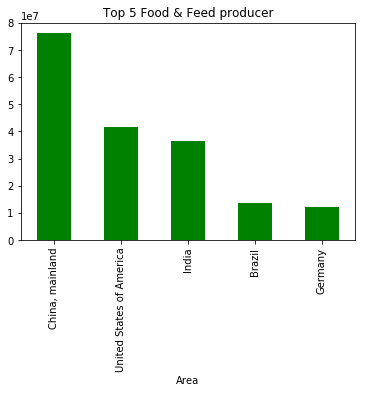

In [10]:
# Finding the Top 5 producer of Feed and Food from 1961 to 2013
df_fao_tot = df_fao.sum(axis=0).sort_values(ascending=False).head()
df_fao_tot.plot(kind='bar', title='Top 5 Food & Feed producer', color='g')

#### COMMENT: 
It not surprisingly appeared as China is the country with the biggest amount of Food and Feed production, it is the most populous country in the world and also one of the biggest, with over 1 billion people to feed, there are a lot of food to produce. China is followed by USA and India respectively 3rd and 2nd most populous countries. 
It is logical to think that this rank isn't affected only by the amount of population of a country, but also by GDP, total cultivable area, and geographical position.

## RANK FOR JUST FOOD OR FEED

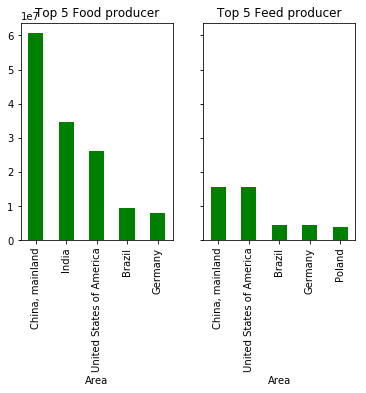

In [11]:
#Producer of just Food
df_food = df_fao.xs('Food', level=1, axis=0)
df_food_tot = df_food.sum(axis=0).sort_values(ascending=False).head()
#Producer of just Feed
df_feed = df_fao.xs('Feed', level=1, axis=0)
df_feed = df_feed.sum(axis=0).sort_values(ascending=False).head()

#Plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
df_food_tot.plot(kind='bar', title='Top 5 Food producer', color='g', ax=ax1)
df_feed.plot(kind='bar', title='Top 5 Feed producer', color='g', ax=ax2 )

#### COMMENT:
The graph on the left contains only countries producer of Food for humans, is the same as before and this means that Feed production is irrelevant on the total amount. The right graph instead contains only Feed for animals, here is disappeared **India**, probably because the biggest part of Feed is intended for cattle (cows) and those animals are considered sacred there.

## RANK OF MOST PRODUCED ITEMS

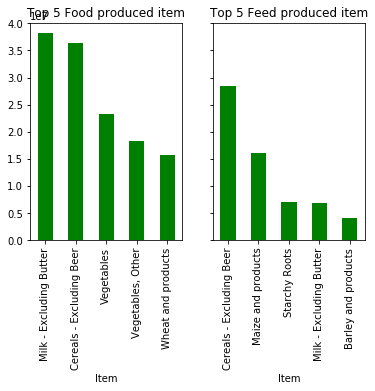

In [12]:
#Rank of most Produced Items 
df_item = df.pivot_table(values=year_list, columns='Element',index=['Item'], aggfunc='sum')
df_item = df_item.T
#FOOD
df_food_item = df_item.xs('Food', level=1, axis=0)
df_food_item = df_food_item.sum(axis=0).sort_values(ascending=False).head()
#FEED
df_feed_item = df_item.xs('Feed', level=1, axis=0)
df_feed_item = df_feed_item.sum(axis=0).sort_values(ascending=False).head()
#Plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
df_food_item.plot(kind='bar', title='Top 5 Food produced item', color='g', ax=ax1)
df_feed_item.plot(kind='bar', title='Top 5 Feed produced item', color='g' , ax=ax2)

#### COMMENT:
From the calculation appears how Milk is the most produced item in the world from 1960 to 2013, followed by cereals and vegetables, regarding feed intended to animals, Cereals and Maize are the most produced items.


## SHOWING DEVELOPING COUNTRIES 

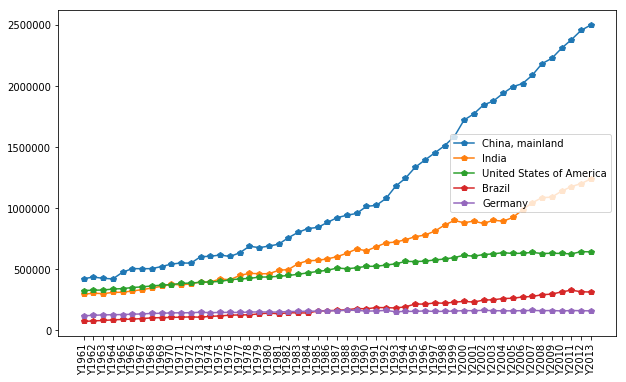

In [13]:
# Visualization of the top 5 producer countries among years
plt.figure(figsize = (10,6))
top_5 = []
for i in df_food_tot.index:
    year = df_food[i]
    top_5.append(year)
    plt.plot(year, marker='p')
    plt.xticks(df_food.index, rotation='vertical')
    plt.legend(loc='right')

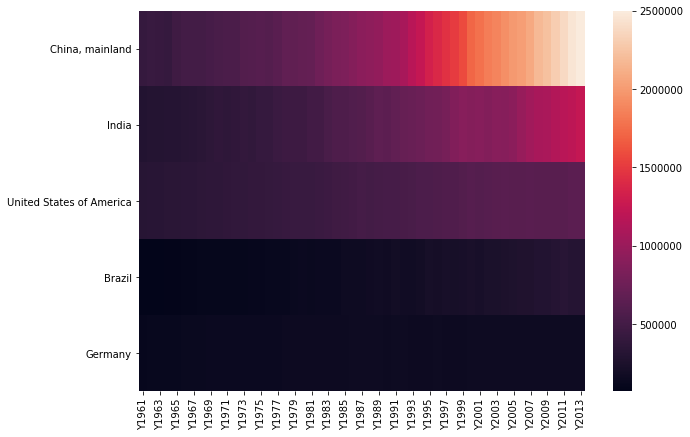

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(data=pd.DataFrame(top_5),linewidths=0, ax=ax)
plt.show()

# CLUSTERING
Clustering is an unsupervised learning method used in order to find new groups from data such that intra-cluster distances are minimized and inter-cluster distances are maximised. 
It doesn't not require any knowledge about the data,
similarly to classification algorithms, clustering algorithms assign (or predict) a number to each data
point, indicating which cluster a particular point belongs to.
There are two different type of clusering:
*                                              PARTITIONAL
*                                              HIERARCHICAL

Hierarchical clustering requires only a similarity measure, while partitional clustering requires stronger assumptions such as number of clusters and the initial centers. Hierarchical clustering returns a much more meaningful and subjective division of clusters but partitional clustering results in exactly k clusters. 

Most common clustering algorithm are: K-Means, Hierarchical, Density-based (DBSCAN).

## DATA PREPARATION

Considering that initially not all the countries of the world are included in the dataset (due probably to political problems) and considering that there are some missing values for existing countries, I've decided to use only information about the last 20 years avalaible (1993-2013) in order also to simplify the amount of data. Remaining missing values are filled with 0 (Belgium, Luxembourg, Montenegro, Serbia, Sudan)


I provide different data structures:  

* COUNTRY - POPULATION - SURFACE - Y1993 ------ Y2013
* COUNTRY - POPULATION - SURFACE - TOTAL 
* ITEM    - Y1993 ------ Y2013 (world wide)
* ITEM    - Y1993 ------ Y2013 (for **Italy**)

In [15]:
d3 = df.loc[:, 'Y1993':'Y2013'] #take only last 20 years
data1 = new_data.join(d3) #recap: new_data does not contains years data

d4 = data1.loc[data1['Element'] == 'Food'] #get just food
d5 = d4.drop('Element', axis=1)
d5 = d5.fillna(0) #substitute missing values with 0

year_list = list(d3.iloc[:,:].columns)
d6 = d5.pivot_table(values=year_list, index=['Area'], aggfunc='sum')

italy = d4[d4['Area'] == 'Italy']
italy = italy.pivot_table(values=year_list, index=['Item'], aggfunc='sum')
italy = pd.DataFrame(italy.to_records())

item = d5.pivot_table(values=year_list, index=['Item'], aggfunc='sum')
item = pd.DataFrame(item.to_records())

d5 = d5.pivot_table(values=year_list, index=['Area', 'Population', 'Surface'], aggfunc='sum')
area = pd.DataFrame(d5.to_records())
d6.loc[:, 'Total'] = d6.sum(axis=1)
d6 = pd.DataFrame(d6.to_records())
d = pd.DataFrame({'Area' : d6['Area'] , 'Total': d6['Total'] , 'Population': area['Population'], 'Surface': area['Surface']})

In [16]:
d.head()

,Area,Total,Population,Surface
0,Afghanistan,326921.0,35530.081,65286.0
1,Albania,120172.0,2930.187,2740.0
2,Algeria,896114.0,41318.142,238174.0
3,Angola,352564.0,29784.193,124670.0
4,Antigua and Barbuda,2079.0,102.012,44.0


In [17]:
data_ = dict(type = 'choropleth',
locations = d['Area'],
locationmode = 'country names',
z = d['Total'],
text = d['Area'],
colorbar = {'title':'Tons of food'})
layout = dict(title = 'Total Production of Food 1993-2013',
geo = dict(showframe = False,
projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data_], layout=layout)
iplot(choromap3)

In [18]:
data_ = dict(type = 'choropleth',
locations = d['Area'],
locationmode = 'country names',
z = d['Population'],
text = d['Area'],
colorbar = {'title':'Tons of food'})
layout = dict(title = 'World Population of 2013',
geo = dict(showframe = False,
projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data_], layout=layout)
iplot(choromap3)

In [19]:
data_ = dict(type = 'choropleth',
locations = d['Area'],
locationmode = 'country names',
z = d['Surface'],
text = d['Area'],
colorbar = {'title':'Tons of food'})
layout = dict(title = 'World Surface',
geo = dict(showframe = False,
projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data_], layout=layout)
iplot(choromap3)

In [20]:
italy.head()

,Item,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,Alcoholic Beverages,4609.0,4626.0,4687.0,4659.0,4610.0,4510.0,4531.0,4633.0,4684.0,...,4571.0,4387.0,4176.0,4289.0,3961.0,3734.0,3634.0,3671.0,3640,3611
1,Animal fats,597.0,614.0,624.0,635.0,644.0,701.0,728.0,691.0,684.0,...,708.0,700.0,719.0,721.0,748.0,722.0,717.0,705.0,732,704
2,Apples and products,1474.0,1322.0,1184.0,1104.0,1140.0,1142.0,1236.0,1276.0,1062.0,...,1261.0,1090.0,1108.0,1135.0,1244.0,1265.0,984.0,816.0,806,1017
3,"Aquatic Animals, Others",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,20.0,21.0,20.0,21.0,23.0,32.0,20,27
4,Aquatic Plants,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [21]:
area.head()

,Area,Population,Surface,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,Afghanistan,35530.081,65286.0,10207.0,10741.0,11365.0,12101.0,12963.0,13431.0,13761.0,...,15838.0,16474.0,16975.0,17856.0,18087.0,19045.0,19642.0,19908.0,21184,21471
1,Albania,2930.187,2740.0,4699.0,5374.0,5419.0,5439.0,4902.0,4978.0,5120.0,...,5647.0,5725.0,5864.0,5785.0,6093.0,6182.0,6573.0,6780.0,6909,6952
2,Algeria,41318.142,238174.0,32016.0,30690.0,32070.0,31411.0,31546.0,33638.0,34649.0,...,44044.0,45161.0,46468.0,45681.0,47480.0,52666.0,54267.0,58375.0,60816,63455
3,Angola,29784.193,124670.0,8262.0,9373.0,9826.0,10196.0,10278.0,11226.0,11422.0,...,15919.0,16882.0,18243.0,19765.0,21779.0,24465.0,25992.0,27455.0,27968,30121
4,Antigua and Barbuda,102.012,44.0,86.0,85.0,81.0,81.0,83.0,83.0,90.0,...,92.0,113.0,108.0,122.0,115.0,114.0,115.0,118.0,113,119


In [22]:
item.head()

,Item,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,Alcoholic Beverages,171162.0,174872.0,179655.0,179189.0,185364.0,186749.0,190468.0,196329.0,203000.0,...,217392.0,222722.0,233310.0,244420.0,244373.0,243452.0,247414.0,256269.0,258895,260701
1,Animal fats,17936.0,17815.0,17527.0,17147.0,17246.0,17615.0,18381.0,19220.0,19333.0,...,20493.0,20630.0,21260.0,21680.0,21764.0,21859.0,22212.0,22489.0,23033,23231
2,Apples and products,39421.0,40229.0,41613.0,45819.0,46653.0,46878.0,47911.0,50089.0,48966.0,...,53489.0,55037.0,57502.0,59278.0,60465.0,60866.0,61898.0,64256.0,68153,70671
3,"Aquatic Animals, Others",259.0,333.0,416.0,463.0,615.0,650.0,640.0,682.0,620.0,...,820.0,936.0,1012.0,979.0,1277.0,1322.0,1340.0,1382.0,1240,1249
4,Aquatic Plants,4747.0,5185.0,5106.0,5332.0,5380.0,6441.0,7270.0,7633.0,7911.0,...,10393.0,10522.0,10710.0,11045.0,11398.0,11811.0,12449.0,13055.0,14208,14307


### DATA FOR CLUSTERING

In [23]:
X = pd.DataFrame({'Total': d['Total'], 'Surface' : d['Surface'], 'Population' : d['Population']})
X.head()

,Total,Surface,Population
0,326921.0,65286.0,35530.081
1,120172.0,2740.0,2930.187
2,896114.0,238174.0,41318.142
3,352564.0,124670.0,29784.193
4,2079.0,44.0,102.012


**Statistical overview of the data**

The following statistical measures can be seen for each column using the describe-function of DataFrame of the pandas library:

* count: number of samples
* mean: the mean of this attribute among all samples
* std: the standard deviation of this attribute
* min: the minimal value of this attribute
* 25%: the lower percentile
* 50%: the median
* 75%: the upper percentile
* max: the maximal value of this attribute

In [24]:
X.describe()

,Total,Surface,Population
count,1.740000e+02,1.740000e+02,1.740000e+02
mean,9.536121e+05,6.978259e+04,4.233778e+04
std,3.500840e+06,1.925273e+05,1.516214e+05
min,1.009000e+03,3.030000e+00,5.534500e+01
25%,5.818175e+04,2.802250e+03,2.622920e+03
50%,1.859880e+05,1.295350e+04,9.585345e+03
75%,6.028142e+05,5.237000e+04,3.116425e+04
max,3.900309e+07,1.637687e+06,1.409517e+06


### BOXPLOT

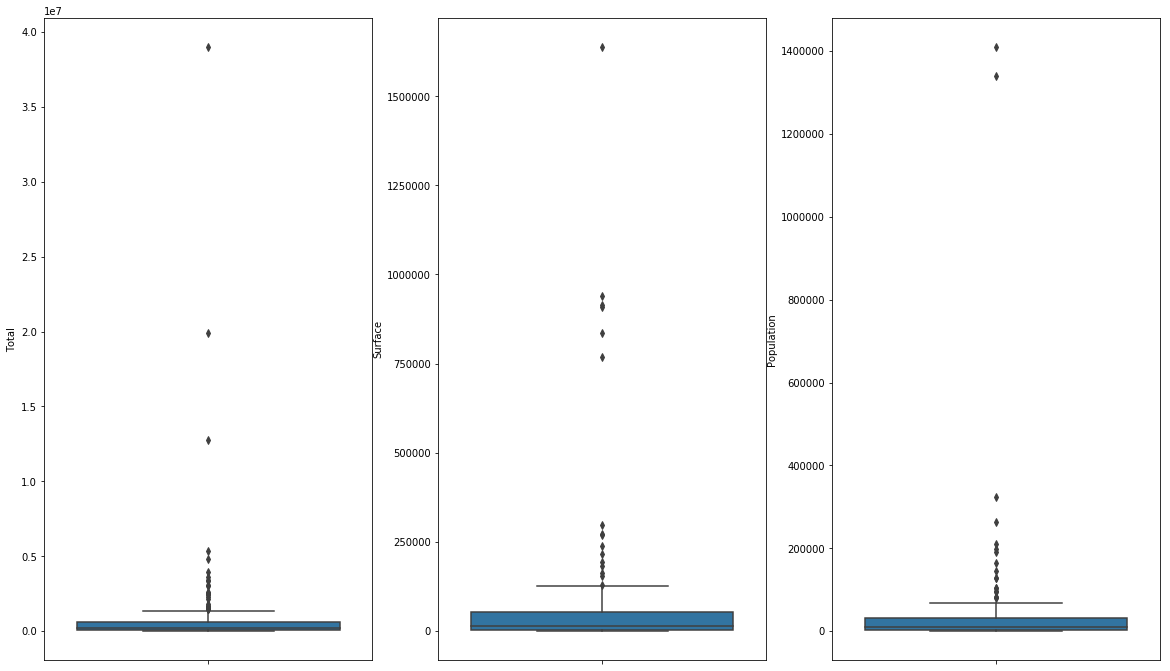

In [25]:
fig = plt.figure(figsize=(20,26))

ax1 = fig.add_subplot(231)
ax1=sns.boxplot(x='Total',data=X, orient='v') 
ax2 = fig.add_subplot(232)
ax2=sns.boxplot(x='Surface',data=X,orient='v')
ax3 = fig.add_subplot(233)
ax3=sns.boxplot(x='Population',data=X, orient='v')

#### COMMENT

From boxplot graphs is possible to see that there are some **outliers** that will surely affect the clustering. 

In order to cluster better the Countries a solution could be to cut-off bigger outliers, for example China and India

### CORRELATION OF VARIABLES
The correlation matrix is simply a table of correlations. The most common correlation coefficient is Pearson’s correlation coefficient, which compares two interval variables or ratio variables, and it's used in this case.

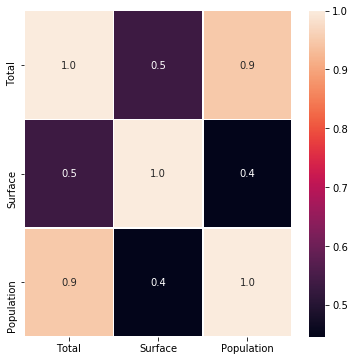

In [26]:
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Population and Total sum of productive have a correlation value of ** 0.9 **<br>
This means that countries that are a lot populous produce a lot of food in order to feed them all.

Population and Surface instead have a correlation value of ** 0.4 **<br>
Is reasonable to unsterstand why they are not correlated

Total amount of Food and Surface have a correlation value of ** 0.5 **<br>
Not all the surface of a country is cultivable

# K-MEANS CLUSTERING
K-Means clustering is one of the simplest and most commonly used clustering algorithms.
It tries to find cluster centers that are representative of certain regions of the
data. The algorithm alternates between two steps: assigning each data point to the
closest cluster center, and then setting each cluster center as the mean of the data
points that are assigned to it. The algorithm is finished when the assignment of
instances to clusters no longer changes.

It's a partitional complete approach, it requires a metric (how to measure distance) and data needs to be normalized. 
The most common way to measure distances is with sum of squared error: 

$$
SSE = \sum_{i=0}^n d(x_i, c_j)^2
$$

K-Means has the advantage that it’s pretty fast, as all we’re really doing is computing the distances between points and group centers. It thus has a linear complexity O(n)

## ELBOW METHOD
It's possible to find the best value of K on a plot of SSE at varing of number of K, from the graph you choose the value of K for which there is the higher slope in our case K=2

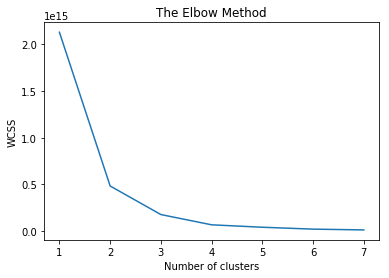

In [27]:
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=7,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## K-MEANS

In [28]:
def K_Means(X, n):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model = KMeans(n)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

### N_CLUSTER = 2

In [29]:
clust_labels, cent = K_Means(X, 2)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

In [30]:
def Plot3dClustering(n, X, type_c): 
    data = []
    clusters = []
    colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(77,175,74)']

    for i in range(n):
        name = i
        color = colors[i]
        x = X[ X[type_c] == i ]['Total']
        y = X[ X[type_c] == i ]['Population']
        z = X[ X[type_c] == i ]['Surface']

        trace = dict(
            name = name,
            x = x, y = y, z = z,
            type = "scatter3d",    
            mode = 'markers',
            marker = dict( size=4, color=color, line=dict(width=0) ) )
        data.append( trace )

        cluster = dict(
            color = color,
            opacity = 0.1,
            type = "mesh3d", 
            alphahull = 7,
            name = "y",
            x = x, y = y, z = z )
        data.append( cluster )

    layout = dict(
        width=800,
        height=550,
        autosize=False,
        title='3D Clustering Plot',
        scene=dict(
            xaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                title='Total Production',
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                title='Population',
                backgroundcolor='rgb(230, 230,230)'
            ),
            zaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                title='Surface Area',
                backgroundcolor='rgb(230, 230,230)'
            ),
            aspectratio = dict( x=1, y=1, z=0.7 ),
            aspectmode = 'manual'        
        ),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig, filename='total_surface_population_plot', validate=False)


In [31]:
Plot3dClustering(n=2, X=X , type_c='kmeans')

In [32]:
cluster1 = pd.DataFrame(d[ X['kmeans'] == 1 ]['Area'])
cluster1

,Area
35,"China, mainland"
74,India


#### COMMENT:

From the analysis **China** and **India** results as outlier. They are both big, popolous and producer countries, and they form a single cluster by them self. 

## N_CLUSTER = 3

In [33]:
clust_labels, cent = K_Means(X, 3)
kmeans = pd.DataFrame(clust_labels)
del X['kmeans']
X.insert((X.shape[1]),'kmeans',kmeans)
Plot3dClustering(n=3, X=X, type_c='kmeans')

### COMMENT
Considerng a number of cluster equal to 3 a new cluster comes out represented by green dots. 

China and India still form a single cluster.

In [34]:
cluster2 = pd.DataFrame(d[ X['kmeans'] == 2 ]['Area'])
cluster2

,Area
7,Australia
21,Brazil
28,Canada
131,Russian Federation
165,United States of America


### FILTERING OUTLIERS 



In [35]:
new_d = d.drop(d[d.Total > 1e7].index)
new_d = new_d.drop(new_d[new_d.Surface > 5e5].index)
new_d = new_d.drop(new_d[new_d.Population > 5e5].index)
X_f = pd.DataFrame({'Total': new_d['Total'], 'Surface' : new_d['Surface'], 'Population' : new_d['Population']})

In [36]:
clust_labels, cent = K_Means(X_f, 2)
kmeans = pd.DataFrame(clust_labels)
X_f.insert((X_f.shape[1]),'kmeans',kmeans)

In [37]:
Plot3dClustering(n=2,X=X_f, type_c='kmeans')

In [38]:
cluster1 = pd.DataFrame(new_d[ X_f['kmeans'] == 1 ]['Area'])
cluster1.head()

,Area
2,Algeria
5,Argentina
10,Bahamas
32,"China, Hong Kong SAR"
46,Djibouti


In [39]:
cluster2 = pd.DataFrame(new_d[ X_f['kmeans'] == 0 ]['Area'])
cluster2

,Area
0,Afghanistan
1,Albania
3,Angola
4,Antigua and Barbuda
6,Armenia
8,Austria
9,Azerbaijan
11,Bangladesh
12,Barbados
13,Belarus


# HIERARCHICAL CLUSTERING

Also known as Agglomerative clustering, does not require the user to specify the number of clusters.
Initially, each point is considered as a separate cluster, then it recursively clusters the points together depending upon the distance between them. The points are clustered in such a way that the distance between points within a cluster is minimum and distance between the cluster is maximum. Commonly used distance measures are Euclidean distance, Manhattan distance or Mahalanobis distance. Unlike k-means clustering, it is "bottom-up" approach, because starting from the leaves and combining clusters up to the trunk.


The approach in small words: 
*  Start with each point in its own cluster.
* Identify the closest two clusters and merge them. • Repeat.
* Ends when all points are in a single cluster.

![](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2016/11/clustergram.png)

In [40]:
def Agglomerative(X, n): #number of clusters is not necessary but Python provides an option of providing the same for easy and simple use.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model = AgglomerativeClustering(n_clusters=n, affinity = 'euclidean', linkage = 'ward')
    clust_labels1 = model.fit_predict(X)
    return (clust_labels1)

In [41]:
clust_labels1 = Agglomerative(X, 2)
agglomerative = pd.DataFrame(clust_labels1)
X.insert((X.shape[1]),'agglomerative',agglomerative)
Plot3dClustering(n=3, X=X, type_c='agglomerative')

In [42]:
cluster0 = pd.DataFrame(d[ X['agglomerative'] == 0 ]['Area'])
cluster0

,Area
7,Australia
21,Brazil
28,Canada
35,"China, mainland"
74,India
131,Russian Federation
165,United States of America


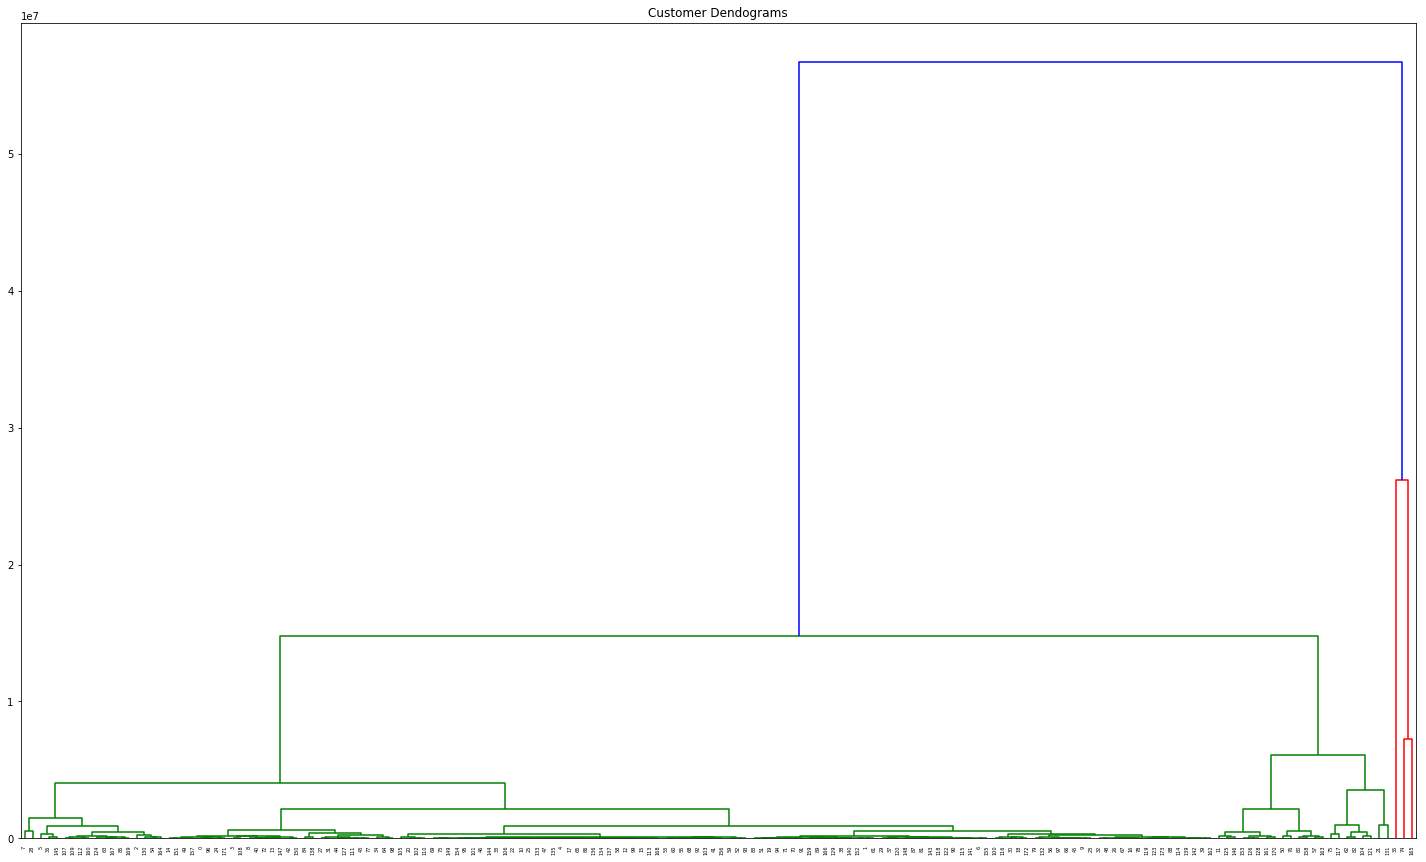

In [43]:
plt.figure(figsize=(25, 15))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

## OTHER RESULTS

* Appling clustering on Items has come out a distinction between most produced and less produced items.<br>
  Most produced items are: **Cereals, Fruits, Milk, Rice, Starchy Roots, Vegetables, Wheat**


* Appling clustering on **Italy**'s Items emerge: **Milk** is the most produced Item (forming a cluster alone by itself)<br> Followed by **Vegetables, Cereals, Fruits, Meat, Alcoholic Beverages and Wine** 


* Considering all years (Y1993-Y2013) instead of Total results does not change.
 